### Импорты: назначение библиотек

- **`os`**: стандартная библиотека Python для работы с файловой системой (поиск, удаление, обработка файлов).
- **`struct`**: библиотека для работы с двоичными файлами (чтение заголовков, упаковка/распаковка данных).
- **`numpy`**: библиотека для работы с массивами данных и выполнения высокопроизводительных вычислений.
- **`intvalpy`**: библиотека для интервального анализа, предоставляющая инструменты работы с интервалами и линейной алгеброй.
- **`matplotlib.pyplot`**: библиотека для создания графиков и визуализации данных.
- **`seaborn`**: расширение для визуализации, упрощающее построение гистограмм, тепловых карт и других видов графиков.
- **`Path` из `pathlib`**: современный инструмент для работы с путями и директориями.
- **`tqdm`**: библиотека для отображения прогресс-баров при выполнении циклов.
- **`math`**: стандартная библиотека для работы с математическими функциями.


In [1]:
import os
import struct
import numpy as np
import intvalpy as ip
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import math

### Функция `read_bin_file_with_numpy`

**Назначение:** чтение бинарного файла, содержащего данные о кадрах, и преобразование его содержимого в массив NumPy.

#### Шаги выполнения:
1. **Чтение заголовка файла (256 байт):**
   - Первые 4 байта интерпретируются как:
     - `side`: сторона измерения;
     - `mode`: режим работы;
     - `frame_count`: количество кадров.
2. **Чтение данных каждого кадра:**
   - Заголовок кадра (16 байт) содержит:
     - `stop_point`: позиция остановки;
     - `timestamp`: временная метка.
   - Данные кадра (16 * 1024 байт) читаются как массив точек (`<8H` — массив из 8 16-битных целых чисел).
3. **Сбор всех данных:** все кадры добавляются в список и возвращаются в виде массива NumPy.

**Применение:**
- Получение структурированных данных для анализа, таких как временные ряды или пространственные измерения.

In [2]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

### Функция `convert_to_voltage`

**Назначение:** преобразует данные из двоичного формата в значения напряжения для анализа.

#### Формула преобразования:
$
\text{voltage} = \frac{\text{data}}{16384.0} - 0.5
$

**Обоснование:**
- Нормализация данных в диапазон $[-0.5, 0.5]$ для упрощения анализа.

In [3]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

### Функция `scalar_to_interval`

**Назначение:** преобразует скалярное значение в интервал с заданным радиусом неопределенности.

#### Пример:
- Если $x = 5.0$ и радиус $rad = 0.1$, то интервал: $[4.9, 5.1]$.

**Применение:**
- Учет неопределенности в измерениях и данных при анализе.
- Создание интервальных данных для последующего использования в методах интервального анализа.

In [4]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

### Функция `get_iqr`

**Назначение:** вычисление межквартильного размаха (IQR) данных.

#### Формулы:
- $Q_1$ — первый квартиль (25%).
- $Q_3$ — третий квартиль (75%).
- $\text{IQR} = Q_3 - Q_1$.

**Применение:**
- Выявление выбросов и определение плотности распределения данных.


In [5]:
def get_iqr(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  return q1, q3

### Функция `get_box_plot`

**Назначение:** вычисление нижней и верхней границы для построения коробчатой диаграммы (box plot).

#### Формулы:
- Нижняя граница: $\text{lower bound} = Q_1 - 1.5 \times \text{IQR}$.
- Верхняя граница: $\text{upper bound} = Q_3 + 1.5 \times \text{IQR}$.

**Применение:**
- Визуализация распределения данных и выявление выбросов.


In [6]:
def get_box_plot(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return lower_bound, upper_bound

### Функция `intersect_intervals`

**Назначение:** нахождение пересечения списка интервалов.

#### Принцип работы:
1. Если список пуст, возвращается $\text{NaN}$.
2. Пересечение интервалов определяется как $[\max(a_1, a_2, ...), \min(b_1, b_2, ...)]$.

**Применение:**
- Определение области перекрытия нескольких интервалов (например, для оценки общей неопределенности).

In [7]:
def intersect_intervals(intervals):
  if len(intervals) == 0:
    return ip.Interval(np.nan, np.nan)

  result = intervals[0]

  if len(intervals) == 1:
    return result

  for interval in intervals:
    result = ip.intersection(result, interval)

  return result

### Функция `are_intersected`

**Назначение:** проверяет, пересекаются ли два интервала.

#### Формула проверки:
- Интервалы $[a_1, b_1]$ и $[a_2, b_2]$ пересекаются, если:
$
sup = \max(a_1, a_2), \quad inf = \min(b_1, b_2), \quad sup - inf \leq 10^{-15}.
$

**Применение:**
- Учет граничных пересечений в интервальном анализе.


In [8]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [9]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

### Функция `merge_intervals`

**Назначение:** объединяет два пересекающихся или смежных интервала в один.

#### Пример:
- Интервалы $[1, 3]$ и $[3, 5]$ объединяются в $[1, 5]$.

**Применение:**
- Упрощение структуры данных, особенно при анализе плотности распределений.

In [10]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

### Функция `mode`

**Назначение:** находит наиболее частые интервалы (моду) в списке интервалов.

#### Шаги выполнения:
1. Определяются все границы интервалов (начало и конец).
2. Формируются интервалы между этими границами.
3. Подсчитывается количество исходных интервалов, перекрывающих каждый новый интервал.
4. Выбираются интервалы с максимальной частотой.

**Применение:**
- Анализ плотности данных и нахождение областей с наибольшей концентрацией значений.

In [11]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

### Функция `med_k`

**Назначение:** вычисляет медиану как интервал между медианами начальных и конечных точек интервалов.

#### Пример:
- Для интервалов $[1, 3]$, $[2, 4]$, $[3, 5]$:
  - Начала: $[1, 2, 3]$, медиана $= 2$.
  - Концы: $[3, 4, 5]$, медиана $= 4$.
  - Итоговый интервал: $[2, 4]$.

**Применение:**
- Представление центрального значения в интервальном виде.

In [12]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

### Визуализация данных

**Цель:**
1. Построение графиков значений из бинарных файлов.
2. Использование гистограмм для анализа распределений.

#### Особенности:
- Графики создаются для каждого файла.
- Используются библиотеки `matplotlib` и `seaborn` для наглядного представления данных.

**Применение:**
- Первичный анализ данных перед проведением интервального анализа.

### Работа с файлами: загрузка и сортировка

1. **Импорты:**
   - `Path` из модуля `pathlib` используется для работы с путями файлов и директорий в удобном формате.
   - `os` необходим для работы с содержимым директорий.

2. **Инициализация папки данных:**
   - `data_folder = Path('data')` создаёт объект `Path`, указывающий на папку `data`. Это базовая директория, где хранятся файлы данных.

3. **Сортировка файлов:**
   - `os.listdir(data_folder)` возвращает список всех файлов и папок в директории `data`.
   - `if f.endswith('.bin')` фильтрует файлы с расширением `.bin`.
   - `data_folder / f` формирует полный путь к файлу (объединяя путь директории с именем файла).
   - `sorted([...])` упорядочивает файлы в алфавитном порядке, что полезно для последовательной обработки данных.

4. **Результат:**
   - `files` содержит отсортированный список путей к файлам с расширением `.bin` в папке `data`. Это упрощает дальнейшую обработку.

In [13]:
data_folder = Path('data')
files = sorted([data_folder / f for f in os.listdir(data_folder) if f.endswith('.bin')])
files

[WindowsPath('data/-0.027_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.205_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.471_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.492_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.061_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.225_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.43_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0_lvl_side_a_fast_data_last.bin')]

### Построение графика точек из файлов

1. **Итерация по файлам:**
   - Для каждого пути из `files` извлекается `file_path`.

2. **Извлечение значения `x`:**
   - `file_path.name` получает имя файла.
   - `.split('_')[0]` разбивает имя файла по символу `_` и берёт первую часть.
   - `float(...)` преобразует строку в число. Это значение интерпретируется как координата `x`.

3. **Чтение кадров из файла:**
   - `read_bin_file_with_numpy(file_path)` читает данные файла, возвращая массив кадров (каждый кадр — массив точек).

4. **Обработка точек кадра:**
   - Для каждого кадра извлекается первая точка: `frame.flatten()[0]`.
   - Значение добавляется в список `ys`.

5. **Построение графика:**
   - `plt.plot([x] * len(ys), ys)` строит точки на графике:
     - `x` повторяется столько раз, сколько значений в `ys` (горизонтальная линия).
     - Значения `ys` отображаются как вертикальные координаты.

6. **Результат:**
   - На графике отображаются вертикальные столбцы точек для каждого файла, соответствующие значениям `ys`.

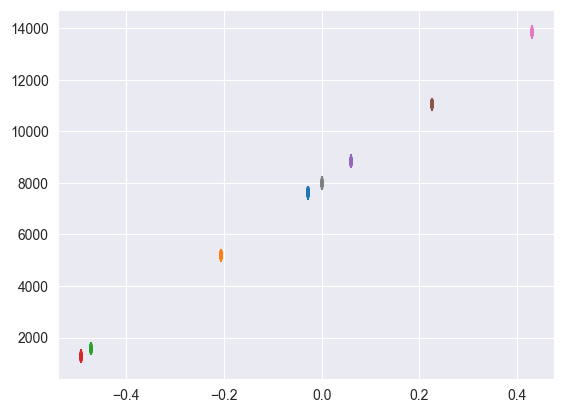

In [14]:
for file_path in files:
  x = float(file_path.name.split('_')[0])
  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  plt.plot([x] * len(ys), ys)

### Построение гистограмм данных

1. **Создание сетки графиков:**
   - `plt.subplots(...)` создаёт сетку из нескольких графиков:
     - Количество строк: `int(math.ceil(len(files) / 2))` (половина от числа файлов, округлённая вверх).
     - Количество столбцов: `2` (фиксированное значение).
     - Размер фигуры: `(15, 20)` задаёт общий размер.

2. **Итерация по файлам:**
   - `enumerate(files)` возвращает индекс `index` и путь к файлу `file_path`.

3. **Определение положения графика:**
   - `row_index = index // 2` вычисляет строку графика.
   - `col_index = index % 2` вычисляет столбец графика.

4. **Чтение данных:**
   - Аналогично предыдущему коду, извлекаются точки из кадров.

5. **Гистограмма:**
   - `sns.histplot(...)` строит гистограмму значений:
     - `ys` — данные для отображения.
     - `bins=25` — число интервалов гистограммы.
     - `stat='frequency'` — отображение частоты.

6. **Добавление заголовка:**
   - `axis.set_title(file_path)` устанавливает имя файла в качестве заголовка графика.

7. **Результат:**
   - Сетка гистограмм для всех файлов, где каждое значение `ys` отображено как частота.

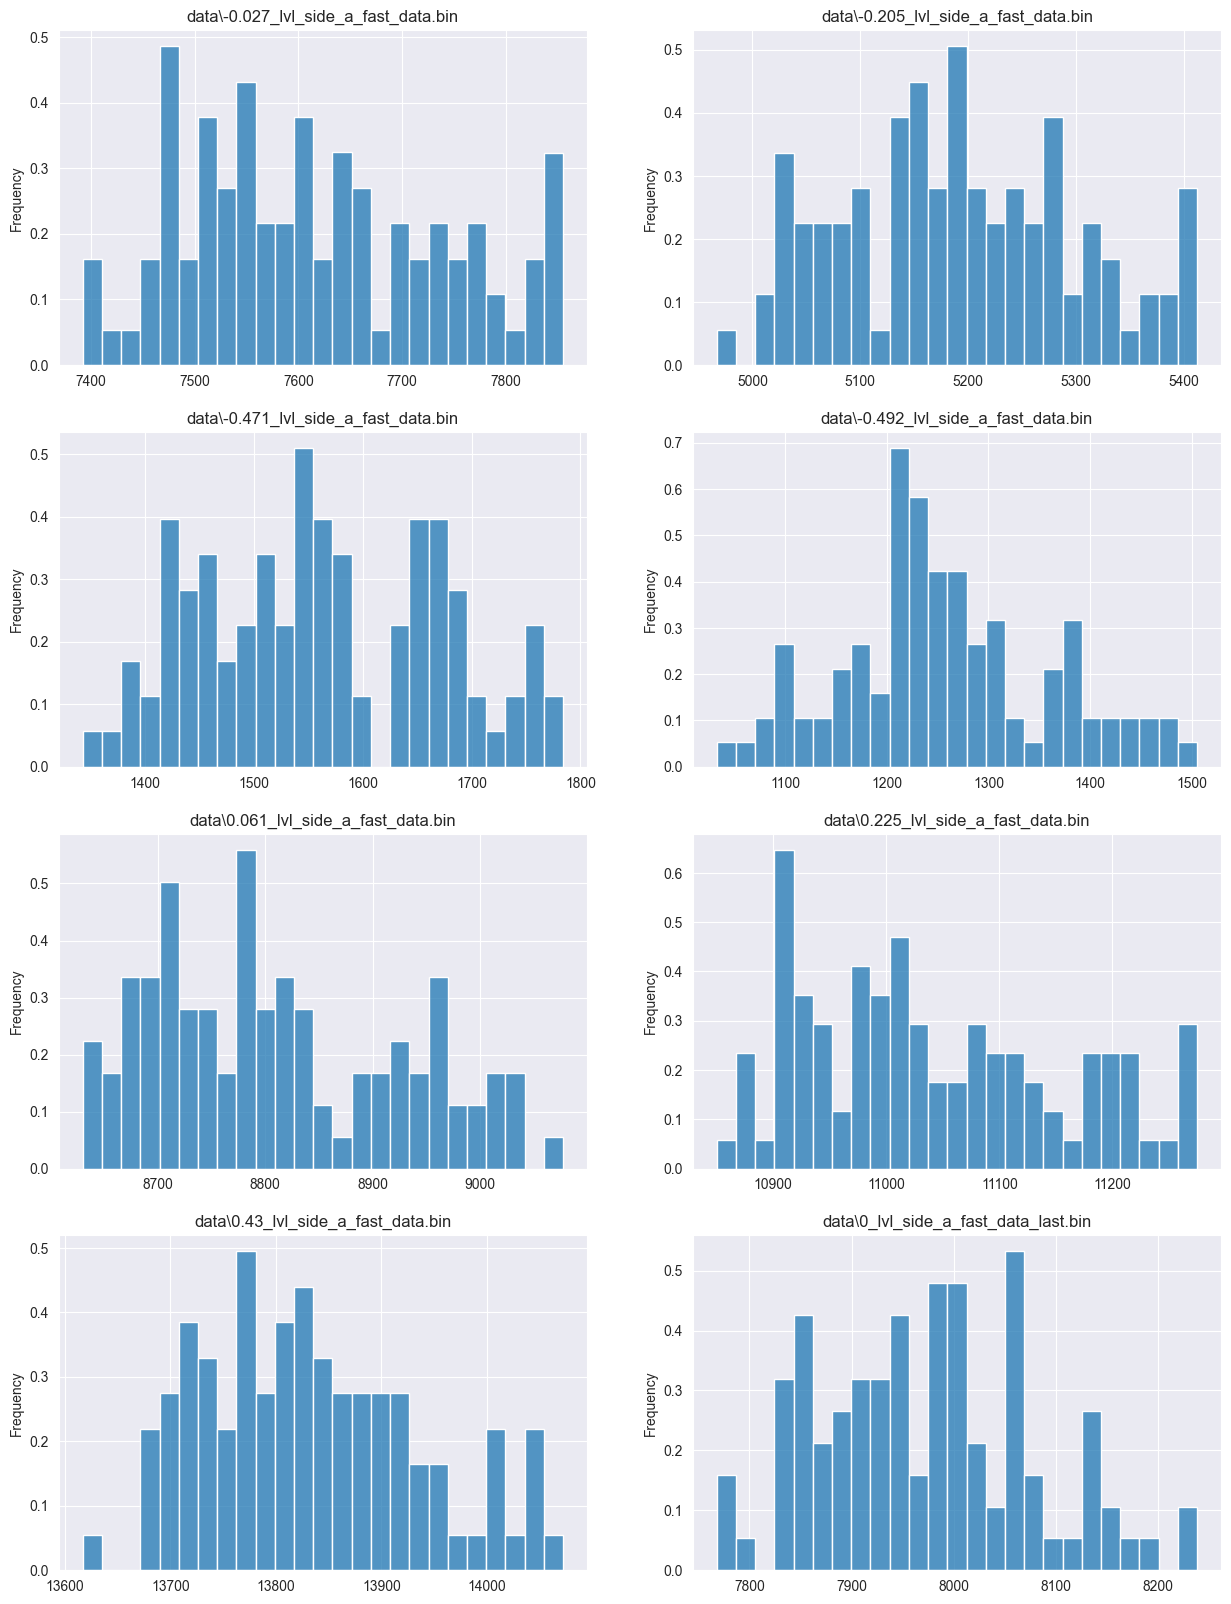

In [15]:
figure, axes = plt.subplots(int(math.ceil(len(files) / 2)), 2, figsize=(15, 20))

for index, file_path in enumerate(files):
  row_index = index // 2
  col_index = index % 2

  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  axis = axes[row_index][col_index]
  sns.histplot(ys, ax=axis, bins=25, stat='frequency')
  axis.set_title(file_path)


In [16]:
rad = 2 ** -9

### Оптимизация и функции `plot_tol_functional`

**Назначение:**
- Построение функции допустимости на основе интервальных данных.
- Вычисление оптимального решения с помощью методов интервальной линейной алгебры.

#### Этапы работы:
1. Максимизация функции допустимости $\text{Tol.maximize}$.
2. Построение карты решений $\text{Tol.value}$ для визуализации области допустимых значений.

**Применение:**
- Оптимизация параметров системы.

In [17]:
def plot_tol_functional(axis, A, b, resolution=21):
  max_tol = ip.linear.Tol.maximize(A, b)
  solution = max_tol[0]
  print(solution)

  x = np.linspace(float(solution[0]) - 2, float(solution[0]) + 2, resolution)
  y = np.linspace(float(solution[1]) -2, float(solution[1]) + 2, resolution)
  xx, yy = np.meshgrid(x, y)
  zz = np.array([[1 if ip.linear.Tol.value(A, b, [x, y]) >= 0 else 0 for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xx, yy)])

  axis.contourf(xx, yy, zz, levels=1, colors=['lightcoral', 'lightgreen'])
  axis.scatter(solution[0], solution[1], color='red', marker='x', s=50)
  axis.set_xlabel('x₁')
  axis.set_ylabel('x₂')

In [18]:
estimation_functions = [
  ('IQR', get_iqr),
  ('Box plot', get_box_plot),
]

### Оценка параметров с использованием интервального анализа

1. **Инициализация радиуса:**
   - `rad = 2 ** -9` задаёт радиус, используемый для формирования интервалов.

2. **Функции оценки:**
   - `estimation_functions` содержит методы оценки (например, `IQR`, `Box Plot`).
   - Итерация по парам `(estimation_name, estimation_f)`.

3. **Обработка пикселей:**
   - `px_num = 1024 * 8` — общее количество пикселей в данных.
   - `tqdm(...)` показывает прогресс обработки.

4. **Формирование матрицы A и вектора b:**
   - `A` и `b` задают интервальные ограничения для решения задачи линейной регрессии.
   - `A.append(...)` добавляет интервалы для коэффициентов регрессии.
   - `b.append(y)` добавляет значения, полученные с использованием функции оценки `estimation_f`.

5. **Интервальная регрессия:**
   - `ip.Interval(A)` и `ip.Interval(b)` создают интервальные объекты.
   - `ip.linear.Rohn(A, b)` решает задачу интервальной регрессии.

6. **Результаты:**
   - Пересечения интервалов (`intersect_intervals`).
   - Оценки по медиане (`med_k`).
   - Моды интервалов (`mode`).

7. **Вывод:**
   - `print(...)` отображает результаты для каждого метода оценки.

In [19]:
rad = 2 ** -9

for estimation_name, estimation_f in estimation_functions:
  beta_0s = []
  beta_1s = []

  px_num = 1024 * 8

  for px_index in tqdm(range(px_num), desc=estimation_name):
    A = []
    b = []

    for file_path in files:
      x = float(file_path.name.split('_')[0])
      frames = read_bin_file_with_numpy(file_path)
      ys = []

      for frame in frames:
        px = frame.flatten()[px_index]
        ys.append(px)

      y = estimation_f(ys)

      A.append([[x - rad, x + rad], [1 - rad, 1 + rad]])
      b.append(y)

    A = ip.Interval(A)
    b = ip.Interval(b)

    x = ip.linear.Rohn(A, b)
    beta_0s.append(x[1])
    beta_1s.append(x[0])

  beta_0_intersected = intersect_intervals(beta_0s)
  beta_1_intersected = intersect_intervals(beta_1s)
  print('Intersection: ', beta_0_intersected, beta_1_intersected)

  beta_0_med_k = med_k(beta_0s)
  beta_1_med_k = med_k(beta_1s)
  print('Med_k: ', beta_0_med_k, beta_1_med_k)

  beta_0_mode = mode(beta_0s)
  beta_1_mode = mode(beta_1s)
  print('Mode: ', beta_0_mode, beta_1_mode)

IQR: 100%|██████████| 8192/8192 [02:24<00:00, 56.79it/s]


Intersection:  '[8077.28, 8077.98]' '[nan, nan]'
Med_k:  '[7986.82, 8233.07]' '[12740.6, 13405.6]'
Mode:  ['[8077.28, 8077.98]'] ['[13177.1, 13183.7]', '[13184.4, 13189.3]']


Box plot: 100%|██████████| 8192/8192 [02:15<00:00, 60.51it/s]


Intersection:  '[7885.3, 8266.58]' '[12977, 13688.5]'
Med_k:  '[7736.37, 8474.22]' '[12072, 14071.8]'
Mode:  ['[7885.3, 8266.58]'] ['[12977, 13688.5]']


### Построение графиков функций регрессии

1. **Интервалы коэффициентов:**
   - `beta_0_int`, `beta_1_int` — интервалы для внутренней регрессии.
   - `beta_0_ext`, `beta_1_ext` — интервалы для внешней регрессии.

2. **Непрерывные значения x:**
   - `xs` извлекает координаты `x` из имён файлов.
   - `xs_continuous` генерирует равномерно распределённые значения.

3. **Генерация y:**
   - `ys = beta_0 + beta_1 * xs_continuous` вычисляет интервальные значения `y`.
   - `ys_a` и `ys_b` — нижние и верхние границы.

4. **Построение графика:**
   - `plt.fill_between(...)` закрашивает область между границами.
   - Границы и среднее значение отображаются красными линиями.


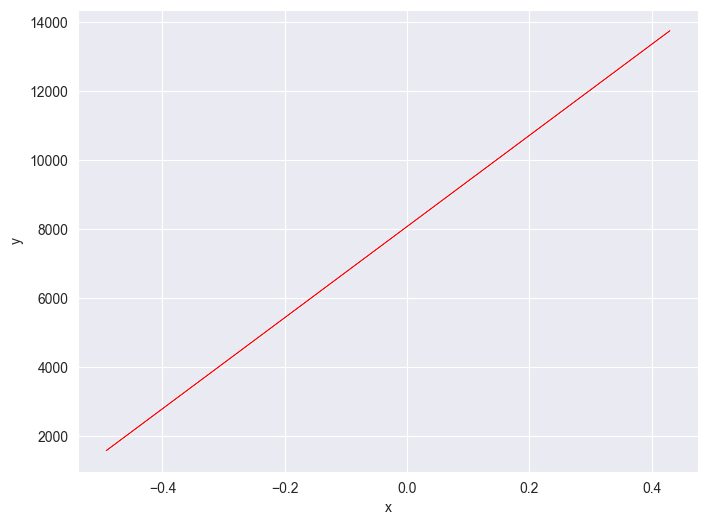

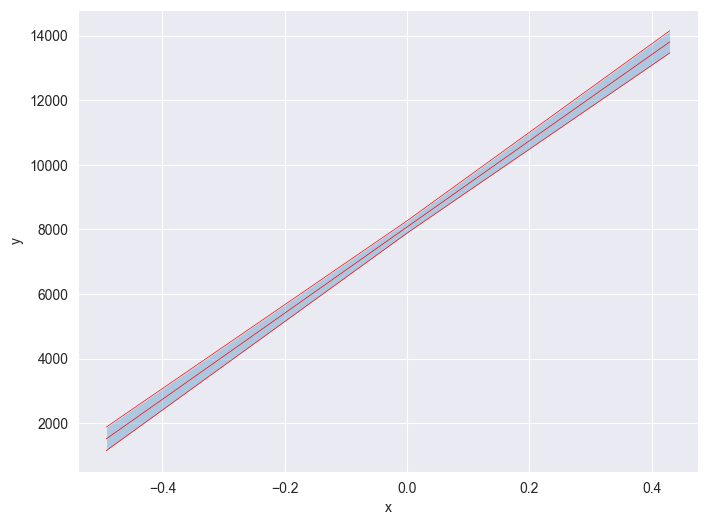

In [20]:
beta_0_int = ip.Interval(8077.28, 8077.98)
beta_1_int = ip.Interval(13184.4, 13189.3)

beta_0_ext = ip.Interval(7885.3, 8266.58)
beta_1_ext = ip.Interval(12977, 13688.5)

xs = np.array([float(file_path.name.split('_')[0]) for file_path in files])
xs_continuous = np.linspace(xs.min(), xs.max(), 100)

for (beta_0, beta_1) in ((beta_0_int, beta_1_int), (beta_0_ext, beta_1_ext)):
  ys = beta_0 + beta_1 * xs_continuous
  ys_a = np.array([float(interval.a) for interval in ys])
  ys_b = np.array([float(interval.b) for interval in ys])

  plt.figure(figsize=(8, 6))
  plt.fill_between(xs_continuous, ys_a, ys_b, alpha=0.3)
  plt.plot(xs_continuous, ys_a, color='red', linewidth=0.5)
  plt.plot(xs_continuous, ys_b, color='red', linewidth=0.5)
  plt.plot(xs_continuous, (ys_a + ys_b) / 2, color='red', linewidth=0.5)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()